In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import signal
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import json
import csv
from scipy import signal
from scipy import interpolate

def interp(x, y, t):
    f = interpolate.interp1d(x, y)
    return f(t)
  
def rms(a):
  return np.sqrt(np.sum(a ** 2.0) / len(a))

In [2]:
import pandas as pd
from pandas import HDFStore

In [3]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style('whitegrid')

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
id_to_desc = {'p1': 'P1: PTP',
 'p10_hdr': 'P10: GGGPFFL',
 'p11_hdr': 'P11: GGGPFL',
 'p12_hdr': 'P12: GGGPOFL',
 'p13_hdr': 'P13: GGGPOL',
 'p14_hdr': 'P14: GGGPc',
 'p15_hdr': 'P15: GGGPc2',
 'p16': 'P16: PN2',
 'p17': 'P17: PN2_2nd',
 'p2': 'P2: PFT',
 'p3': 'P3: POT',
 'p4': 'P4: PFTI',
 'p5': 'P5: POTI',
 'p6_hdr': 'P6: PFI',
 'p7_hdr': 'P7: POI',
 'p8_hdr': 'P8: Pc',
 'p9_hdr': 'P9: Pc2',

 't1': 'T1: TIG1',
 't10': 'T10: THe',
 't11': 'T11: TFTI',
 't12': 'T12: TOTI',
 't13': 'T13: TFIGW',
 't2': 'T2: TIG2',
 't3': 'T3: TFI',
 't4': 'T4: TOI',
 't5': 'T5: TOIW',
 't6': 'T6: GGGTOIW',
 't7': 'T7: GGGTc',
 't8': 'T8: GGGTc2',
 't9': 'T9: TAvio',
 't_a1': 'T-A1',
 't_a2': 'T-A2',
 't_c1': 'T-C1',
 't_d1': 'T-D1',
 't_e2': 'T-E2',
 't_p1': 'T-P1',
 't_p2': 'T-P2'}

In [5]:
def sensor_df(sensor):
    return pd.read_csv('./' + sensor + '.csv', index_col=False)

In [6]:
def plot_sensors(sensors):
    for s in sensors:
        df = sensor_df(s)
        label = s
        if s in id_to_desc:
            label = id_to_desc[s]
        plt.plot(df.iloc[:,0], df.iloc[:,1], label=label)

In [7]:
title = 'MOMO5 Flight (JUNE C-band All Antenna)'

In [8]:
def fill_fired():
    plt.axvspan(0,70,color='red',alpha=0.1)

### GImbal

In [9]:
import math

# https://github.com/istellartech/AvionicsCode/blob/master/designs/momo_gimbal_fm_model/gimbal_model.ipynb
def gimbal_angle_motor_angle():
  width = 77.0
  height = 113.2
  a = math.sqrt(width*width + height*height)
  b = 18.0 #motor arm length
  c = 113.2 #arm length
  d = 95.0 #gimbal arm length
  sigma = math.atan2(width, height)
  sigma_deg = np.rad2deg(sigma)
  #ma = np.array([0.0]) #np.linspace(deg_to_rad(-45.0), deg_to_rad(45.0), 900)
  motor_max_deg = 48
  cnt = int((motor_max_deg*2)/360.0*4096*4)
  ma = np.linspace(np.deg2rad(-motor_max_deg), np.deg2rad(motor_max_deg), cnt)
  tb = np.pi/2.0 - sigma - ma 
  y = np.empty(len(tb))
  for i in range(len(tb)):
      theta_b = tb[i]
      g = np.sqrt(a*a + b*b + 2.0 * a * b * np.cos(theta_b))
      phi = math.acos((d*d+g*g-c*c)/(2.0*d*g)) + math.asin((b*np.sin(theta_b))/g)
      y[i] = phi

  ma_deg = np.rad2deg(ma)  
  motor_degs = np.rad2deg(ma)
  gimbal_degs = np.rad2deg(np.pi/2.0-sigma-y)
  
  ga = np.linspace(-8.0, 8.0, 8*100*2)
  tbl = np.empty(len(ga))
  for i in range(len(ga)):
      error = np.abs(gimbal_degs - ga[i])
      idx = np.argmin(error)
      tbl[i] = motor_degs[idx]
  
  tbl_encoder = (tbl / 360 * 4096 * 4).astype(np.int)
  return np.column_stack((ga, tbl_encoder))
  
def nearest_idx(a, num):
  if isinstance(num, np.ndarray):
    return [nearest_idx(a, x) for x in num]
  return np.abs(np.asarray(a) - num).argmin()
  
def gdeg2enc(gdeg_enc_tbl, gdeg):
  idx = nearest_idx(gdeg_enc_tbl[:,0], gdeg)
  ret = gdeg_enc_tbl[:,1][idx]
  if isinstance(ret, np.ndarray):
    return ret.astype(np.int)
  else:
    return int(ret)

def enc2gdeg(gdeg_enc_tbl, enc):
  idx = nearest_idx(gdeg_enc_tbl[:,1], enc)
  return gdeg_enc_tbl[:,0][idx]

gdeg_enc_tbl = gimbal_angle_motor_angle()


def enc2deg(enc):
    return enc2gdeg(gdeg_enc_tbl, enc)


In [10]:
def interp(x, y, t):
    f = interpolate.interp1d(x, y)
    return f(t)

In [11]:
title = 'MOMO5 Flight (JUNE C-band All Antenna)'

In [12]:
# 元データ取得
df_a_target = sensor_df('gimbal_a_target')
df_a_pos = sensor_df('gimbal_a_position')
df_b_target = sensor_df('gimbal_b_target')
df_b_pos = sensor_df('gimbal_b_position')

df_a_current = sensor_df('gimbal_a_current')
df_b_current = sensor_df('gimbal_b_current')
df_a_voltage = sensor_df('gimbal_a_voltage')
df_b_voltage = sensor_df('gimbal_b_voltage')

In [13]:
#  T-19〜T+70s までの100Hzのデータにする(↓)ための基準時刻
t_gimbal = np.arange(-19, 70, 0.01)

In [14]:
# t_gimbal の時間でリサンプリング(interpolate.interp1d使用)
gimbal_a_target = interp(df_a_target.iloc[:,0], enc2deg(np.array(df_a_target.iloc[:,1])), t_gimbal)
gimbal_b_target = interp(df_b_target.iloc[:,0], enc2deg(np.array(df_b_target.iloc[:,1])), t_gimbal)
gimbal_a_pos = interp(df_a_pos.iloc[:,0], enc2deg(np.array(df_a_pos.iloc[:,1])), t_gimbal)
gimbal_b_pos = interp(df_b_pos.iloc[:,0], enc2deg(np.array(df_b_pos.iloc[:,1])), t_gimbal)

gimbal_a_current =  interp(df_a_current.iloc[:,0], df_a_current.iloc[:,1], t_gimbal)
gimbal_b_current =  interp(df_b_current.iloc[:,0], df_b_current.iloc[:,1], t_gimbal)
gimbal_a_voltage =  interp(df_a_voltage.iloc[:,0], df_a_voltage.iloc[:,1], t_gimbal)
gimbal_b_voltage =  interp(df_b_voltage.iloc[:,0], df_b_voltage.iloc[:,1], t_gimbal)

In [15]:
# 移動平均定義 (10サンプル)
window = 10
c_window = np.ones(window)/window

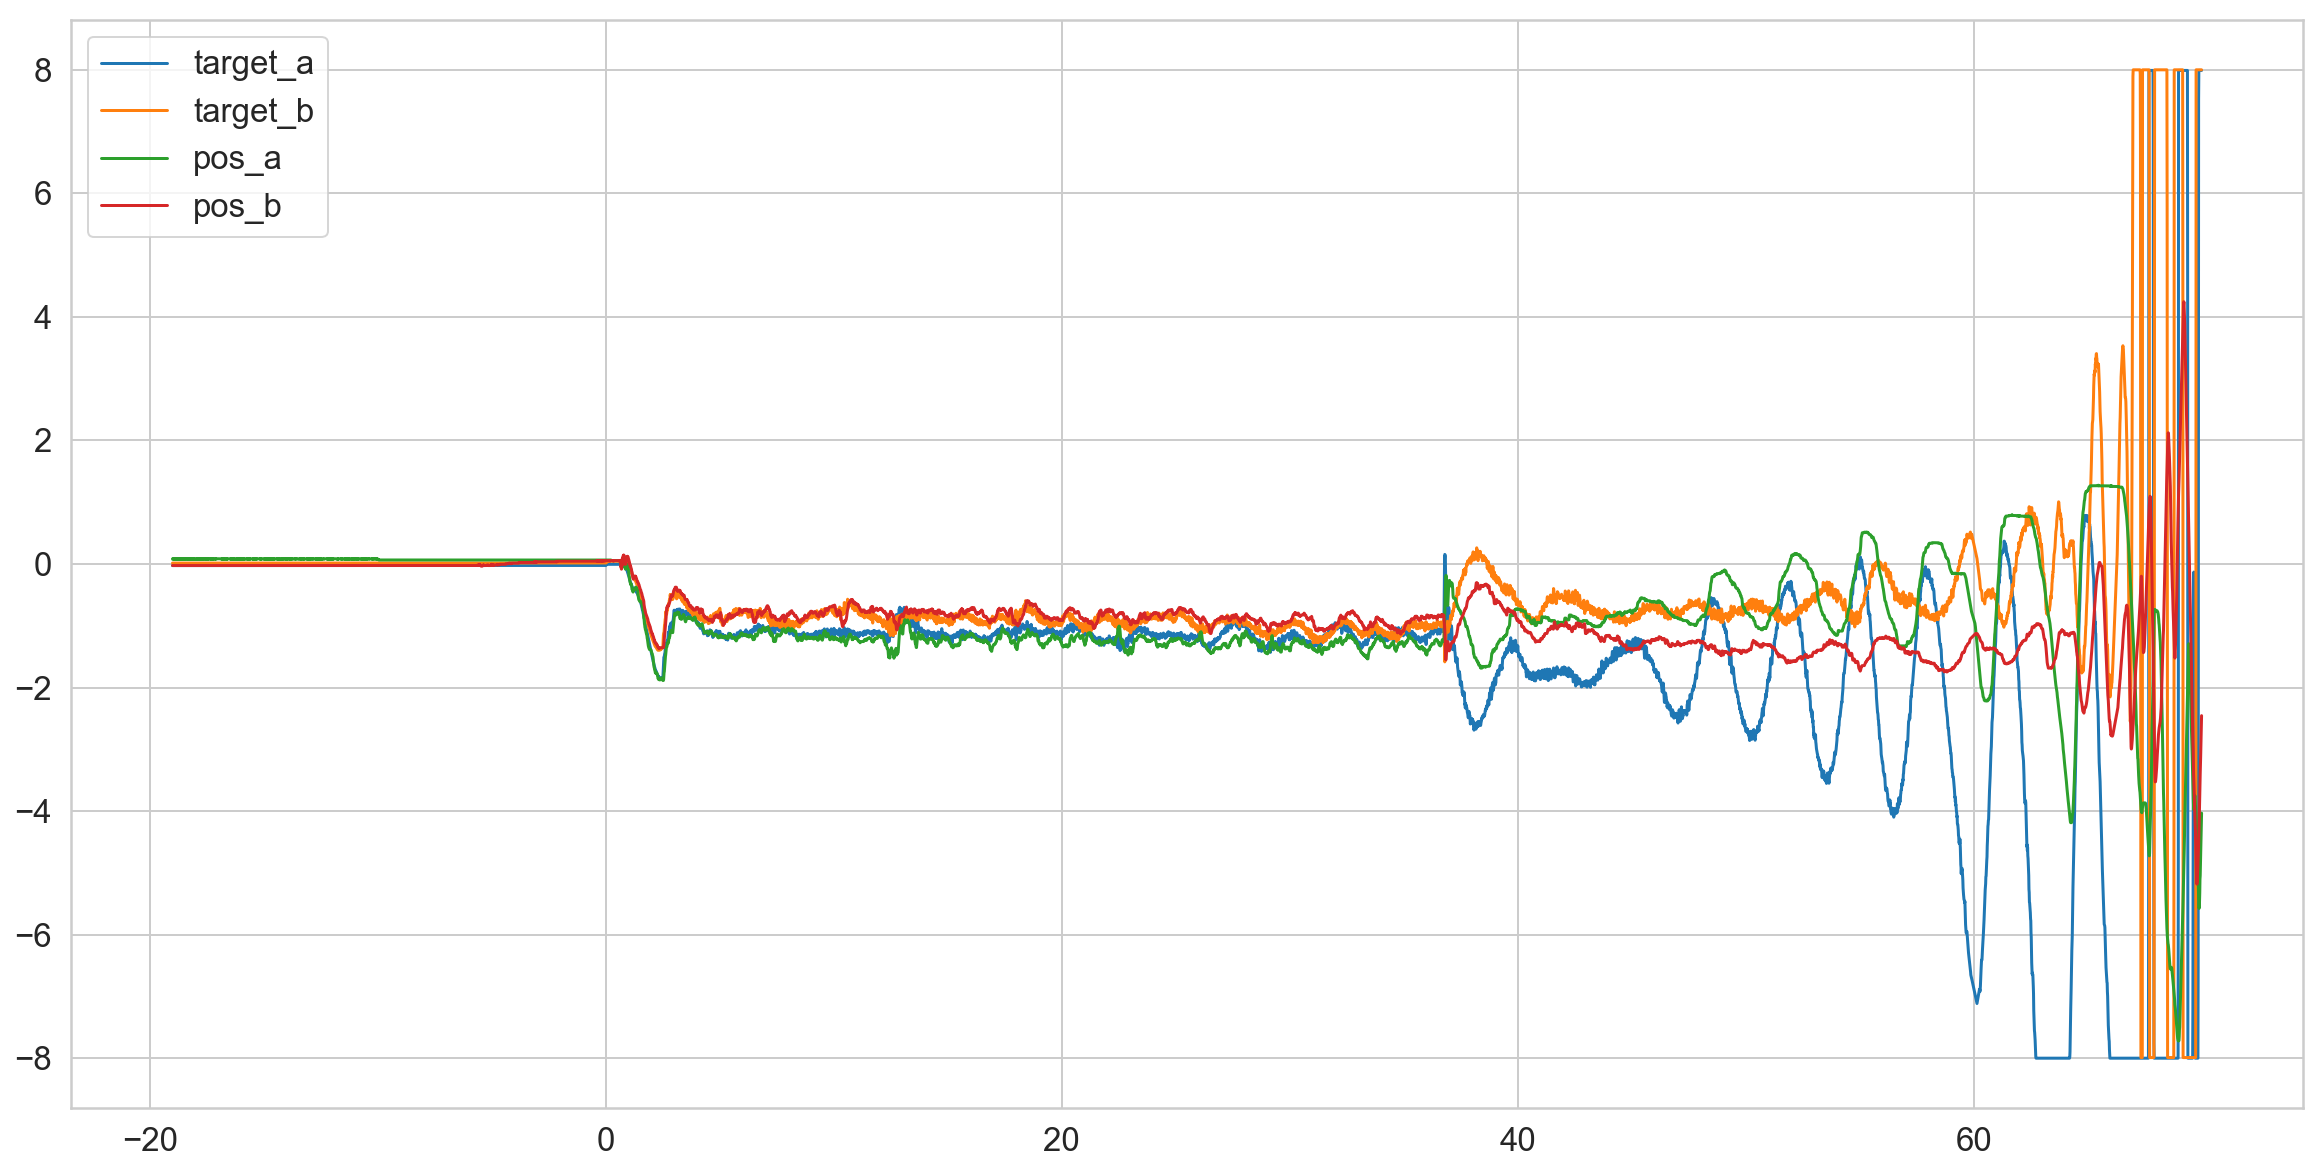

In [16]:
# ジンバル制御(確認用)
plt.plot(t_gimbal, gimbal_a_target, label='target_a')
plt.plot(t_gimbal, gimbal_b_target, label='target_b')
plt.plot(t_gimbal, gimbal_a_pos, label='pos_a')
plt.plot(t_gimbal, gimbal_b_pos, label='pos_b')
plt.legend()

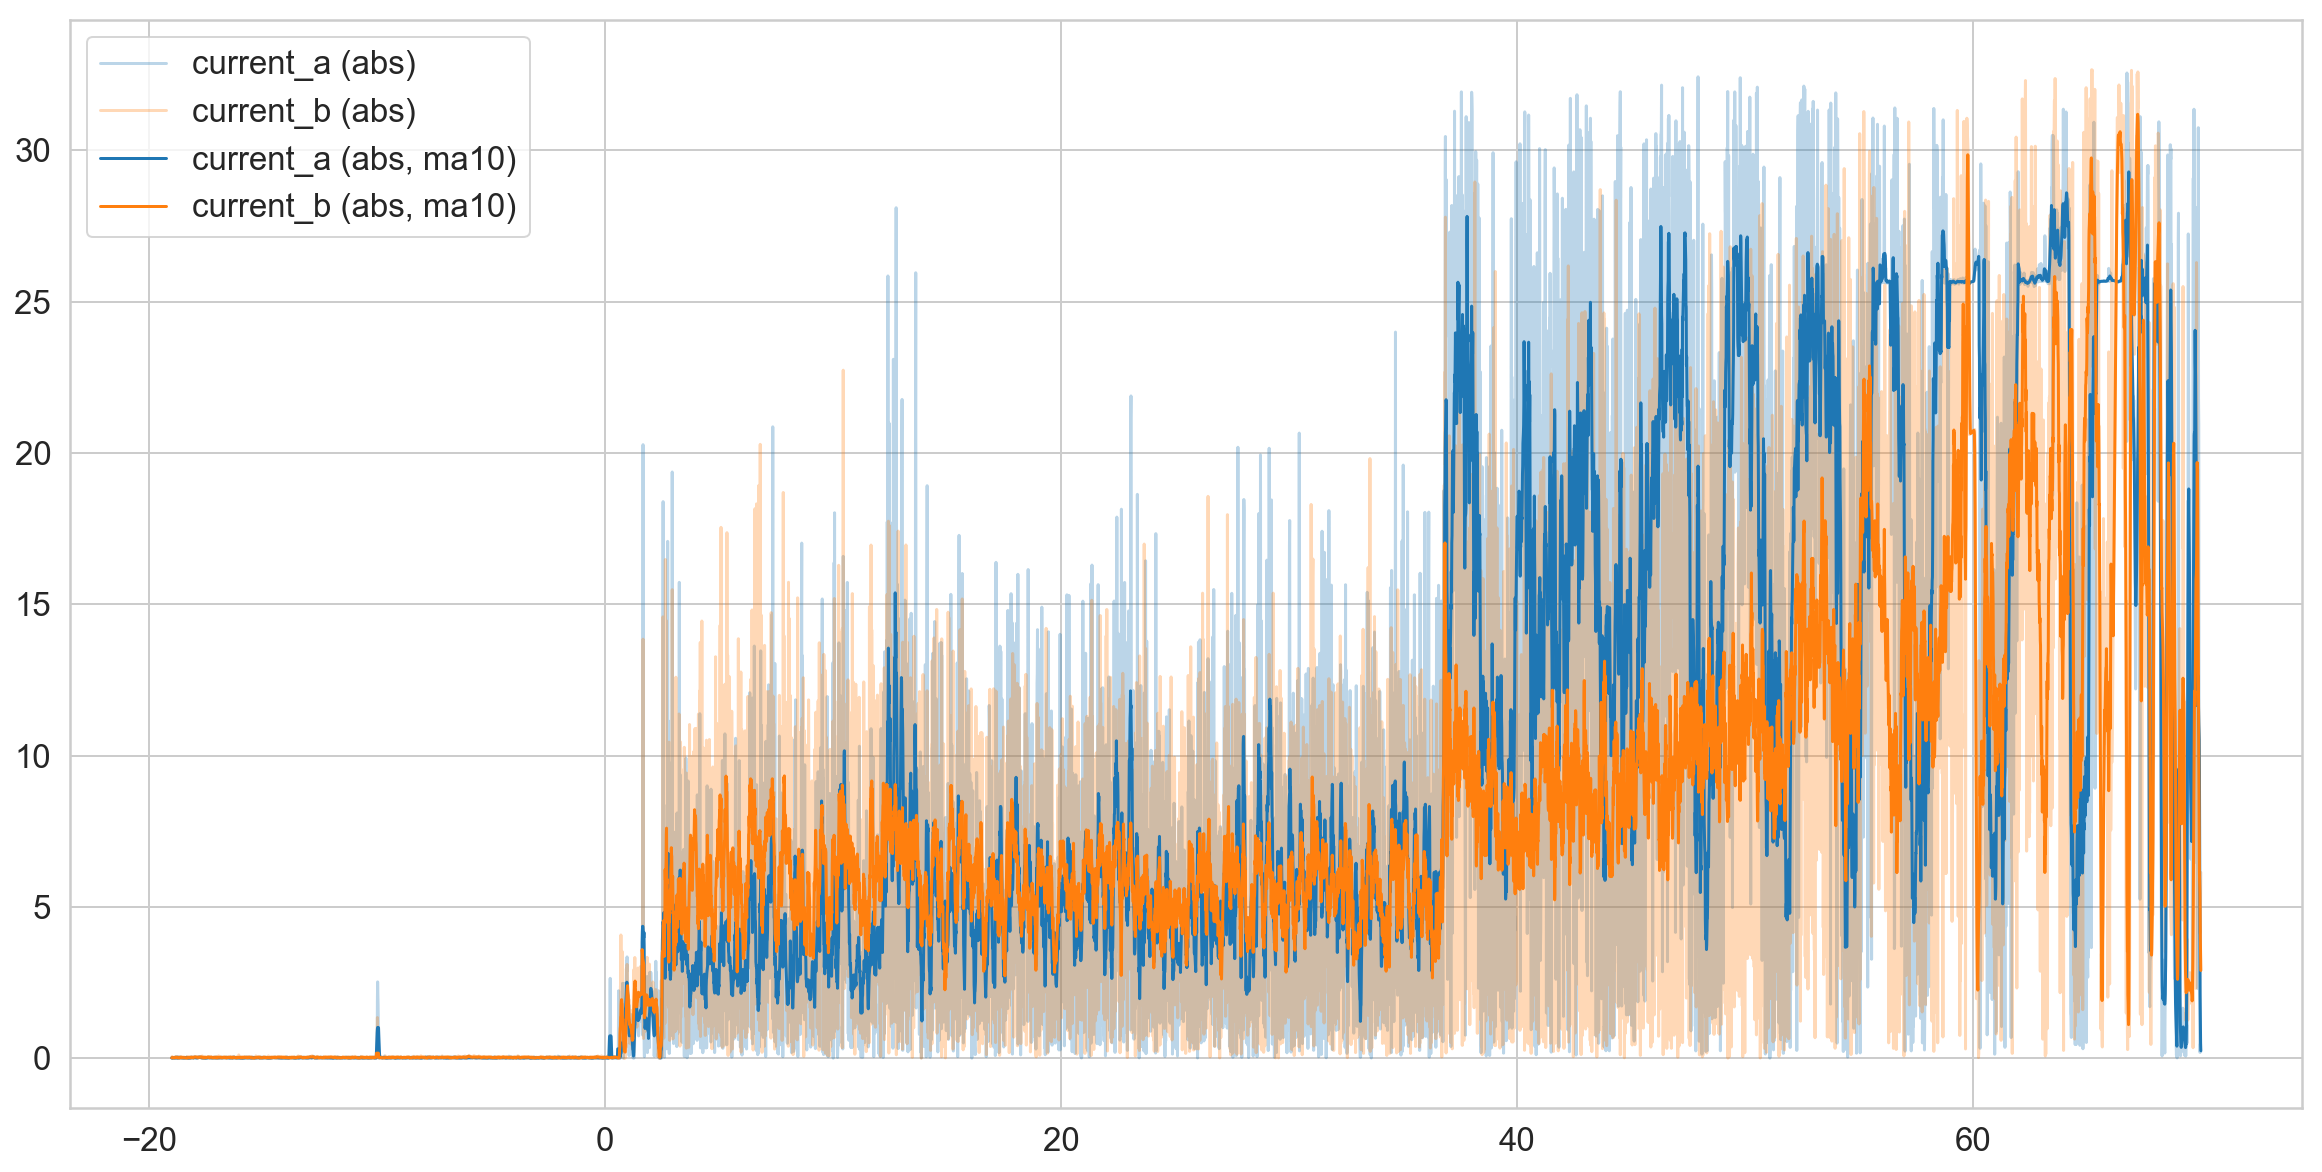

In [17]:
# 電流(確認用)
plt.plot(t_gimbal, np.abs(gimbal_a_current), label='current_a (abs)', alpha=0.3)
plt.plot(t_gimbal, np.abs(gimbal_b_current), label='current_b (abs)', alpha=0.3)

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
gimbal_a_current_ma = np.convolve(np.abs(gimbal_a_current), c_window, mode='same')
gimbal_b_current_mb = np.convolve(np.abs(gimbal_b_current), c_window, mode='same')
plt.plot(t_gimbal, gimbal_a_current_ma, label='current_a (abs, ma10)', color=color_cycle[0])
plt.plot(t_gimbal, gimbal_b_current_mb, label='current_b (abs, ma10)', color=color_cycle[1])

plt.legend()

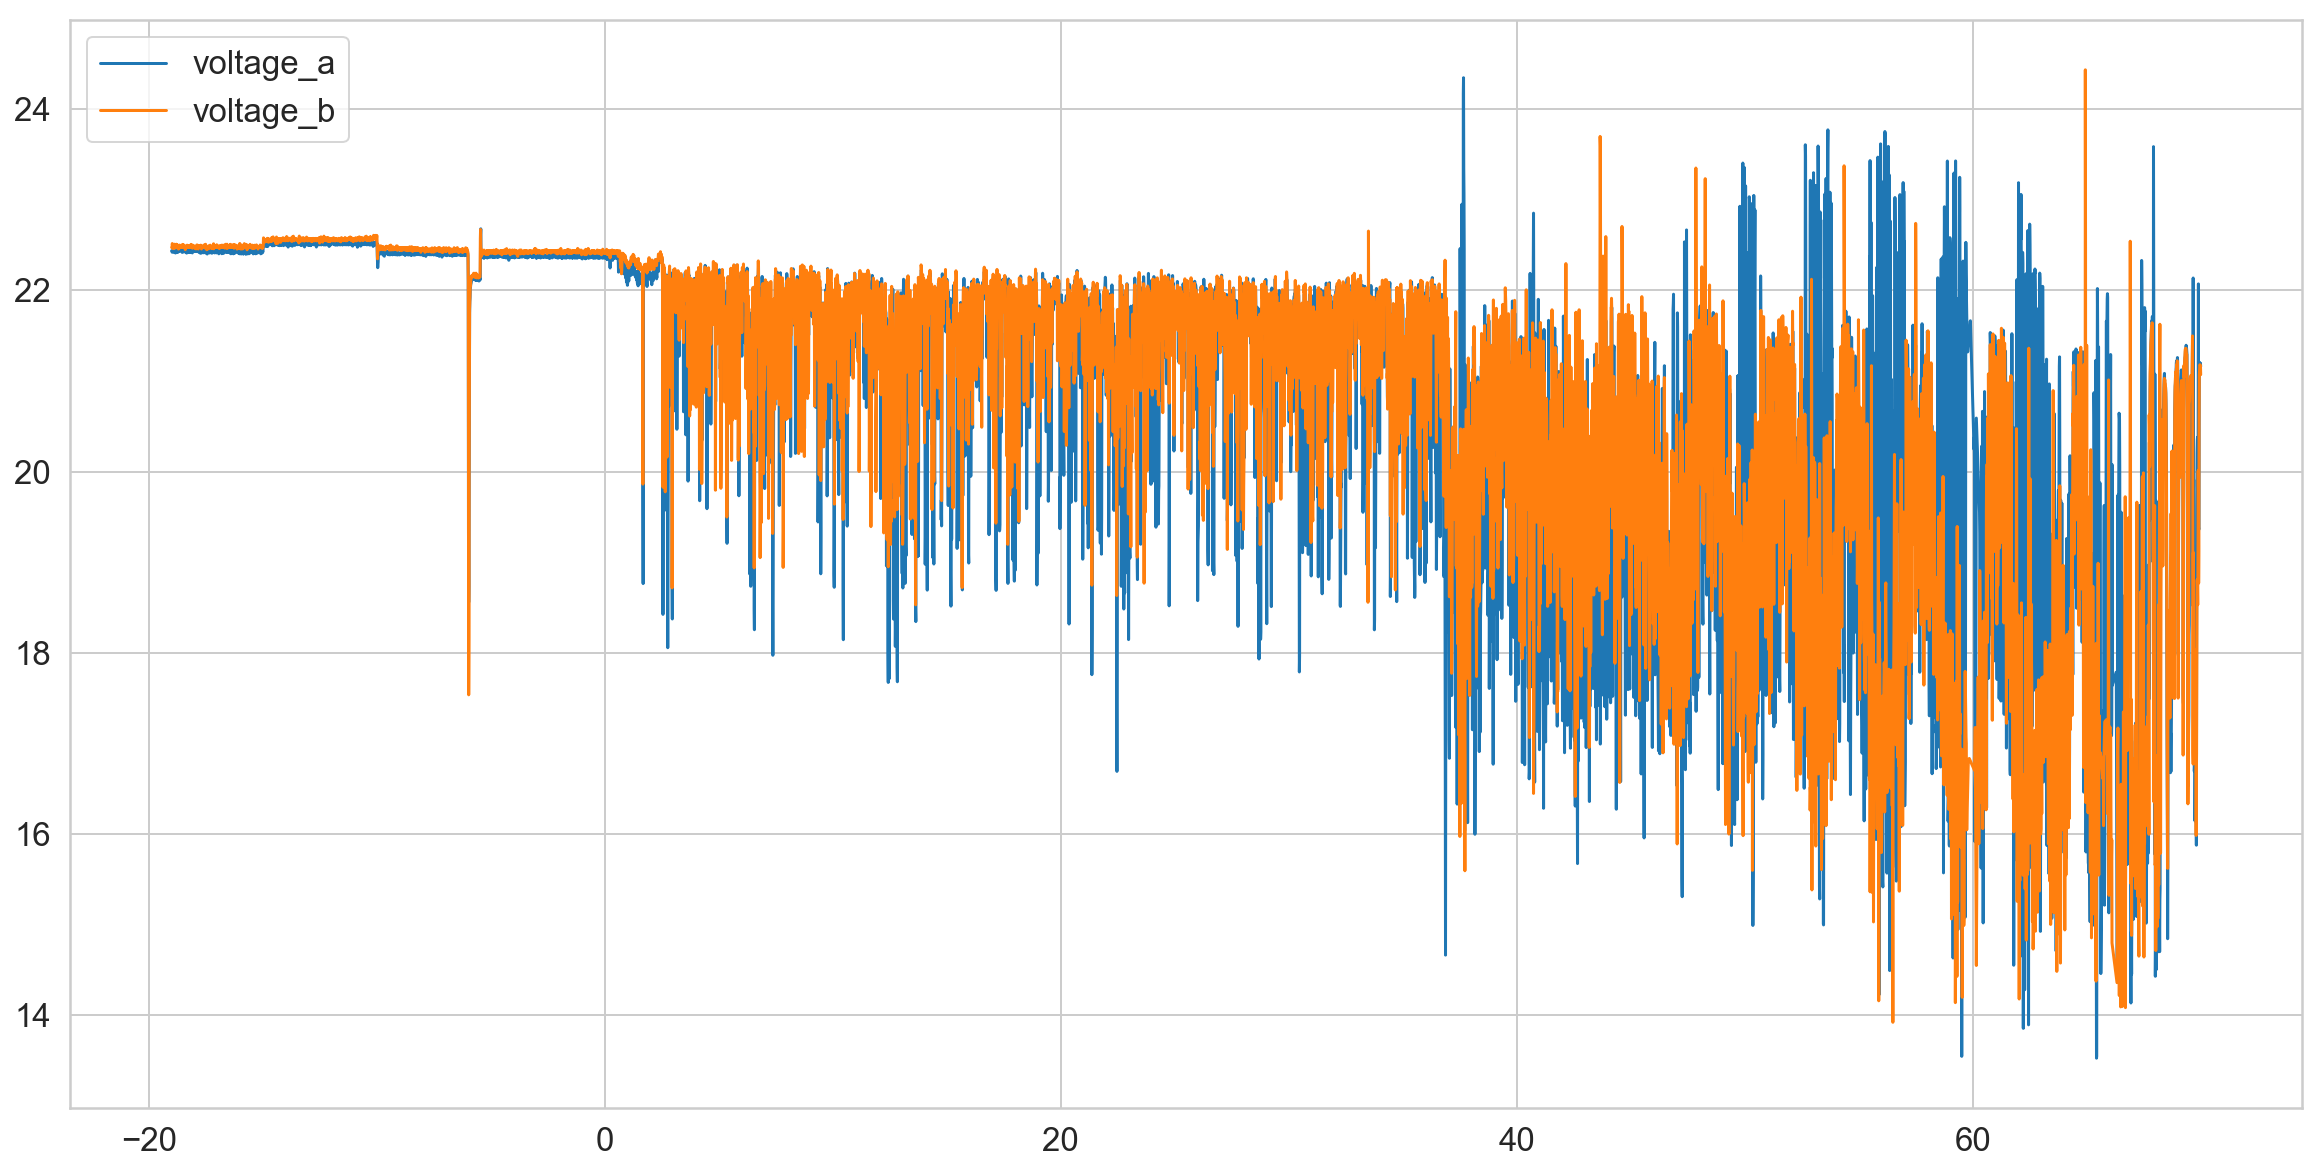

In [18]:
# 電圧(確認用)
plt.plot(t_gimbal, gimbal_a_voltage, label='voltage_a')
plt.plot(t_gimbal, gimbal_b_voltage, label='voltage_b')
plt.legend()

Text(0.5,1,'MOMO5 Flight (JUNE C-band All Antenna)')

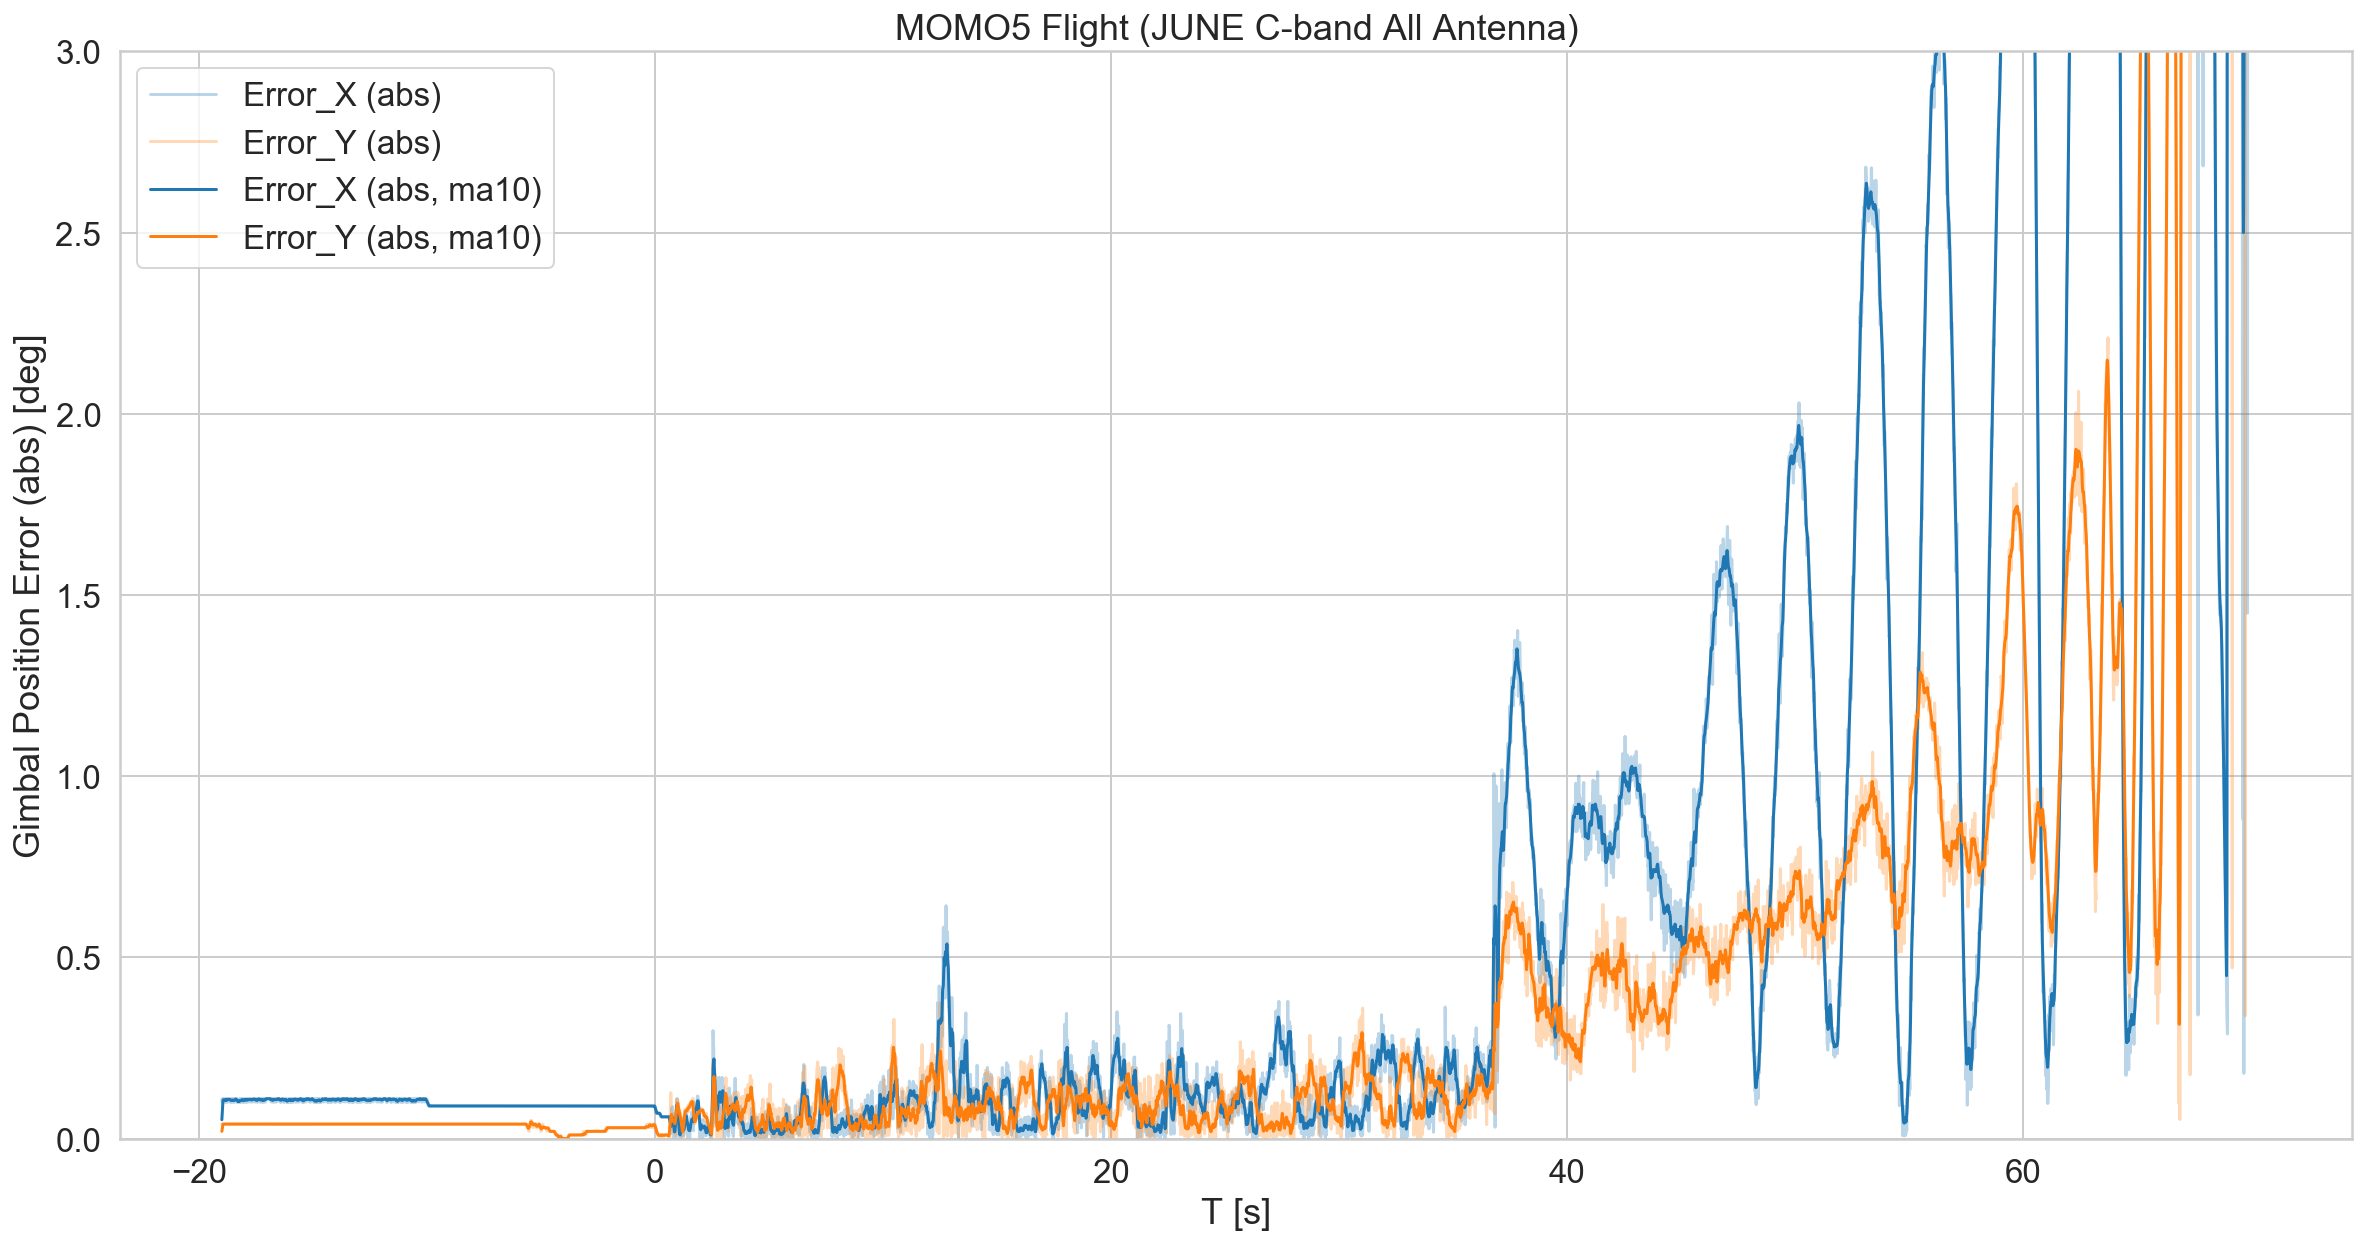

In [19]:
# 位置エラー(ジンバル角、絶対値)

position_error_a = np.abs(gimbal_a_target - gimbal_a_pos)
position_error_b = np.abs(gimbal_b_target - gimbal_b_pos)
position_error_a_ma = np.convolve(position_error_a, c_window, mode='same')
position_error_b_ma = np.convolve(position_error_b, c_window, mode='same')

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(t_gimbal, position_error_a, label='Error_X (abs)', alpha=0.3)
plt.plot(t_gimbal, position_error_b, label='Error_Y (abs)', alpha=0.3)
plt.plot(t_gimbal, position_error_a_ma, label='Error_X (abs, ma10)', color=color_cycle[0])
plt.plot(t_gimbal, position_error_b_ma, label='Error_Y (abs, ma10)', color=color_cycle[1])

plt.legend()
plt.ylim(0, 3)
plt.ylabel('Gimbal Position Error (abs) [deg]')
plt.xlabel('T [s]')
plt.title(title)

Text(0.5,0,'T [s]')

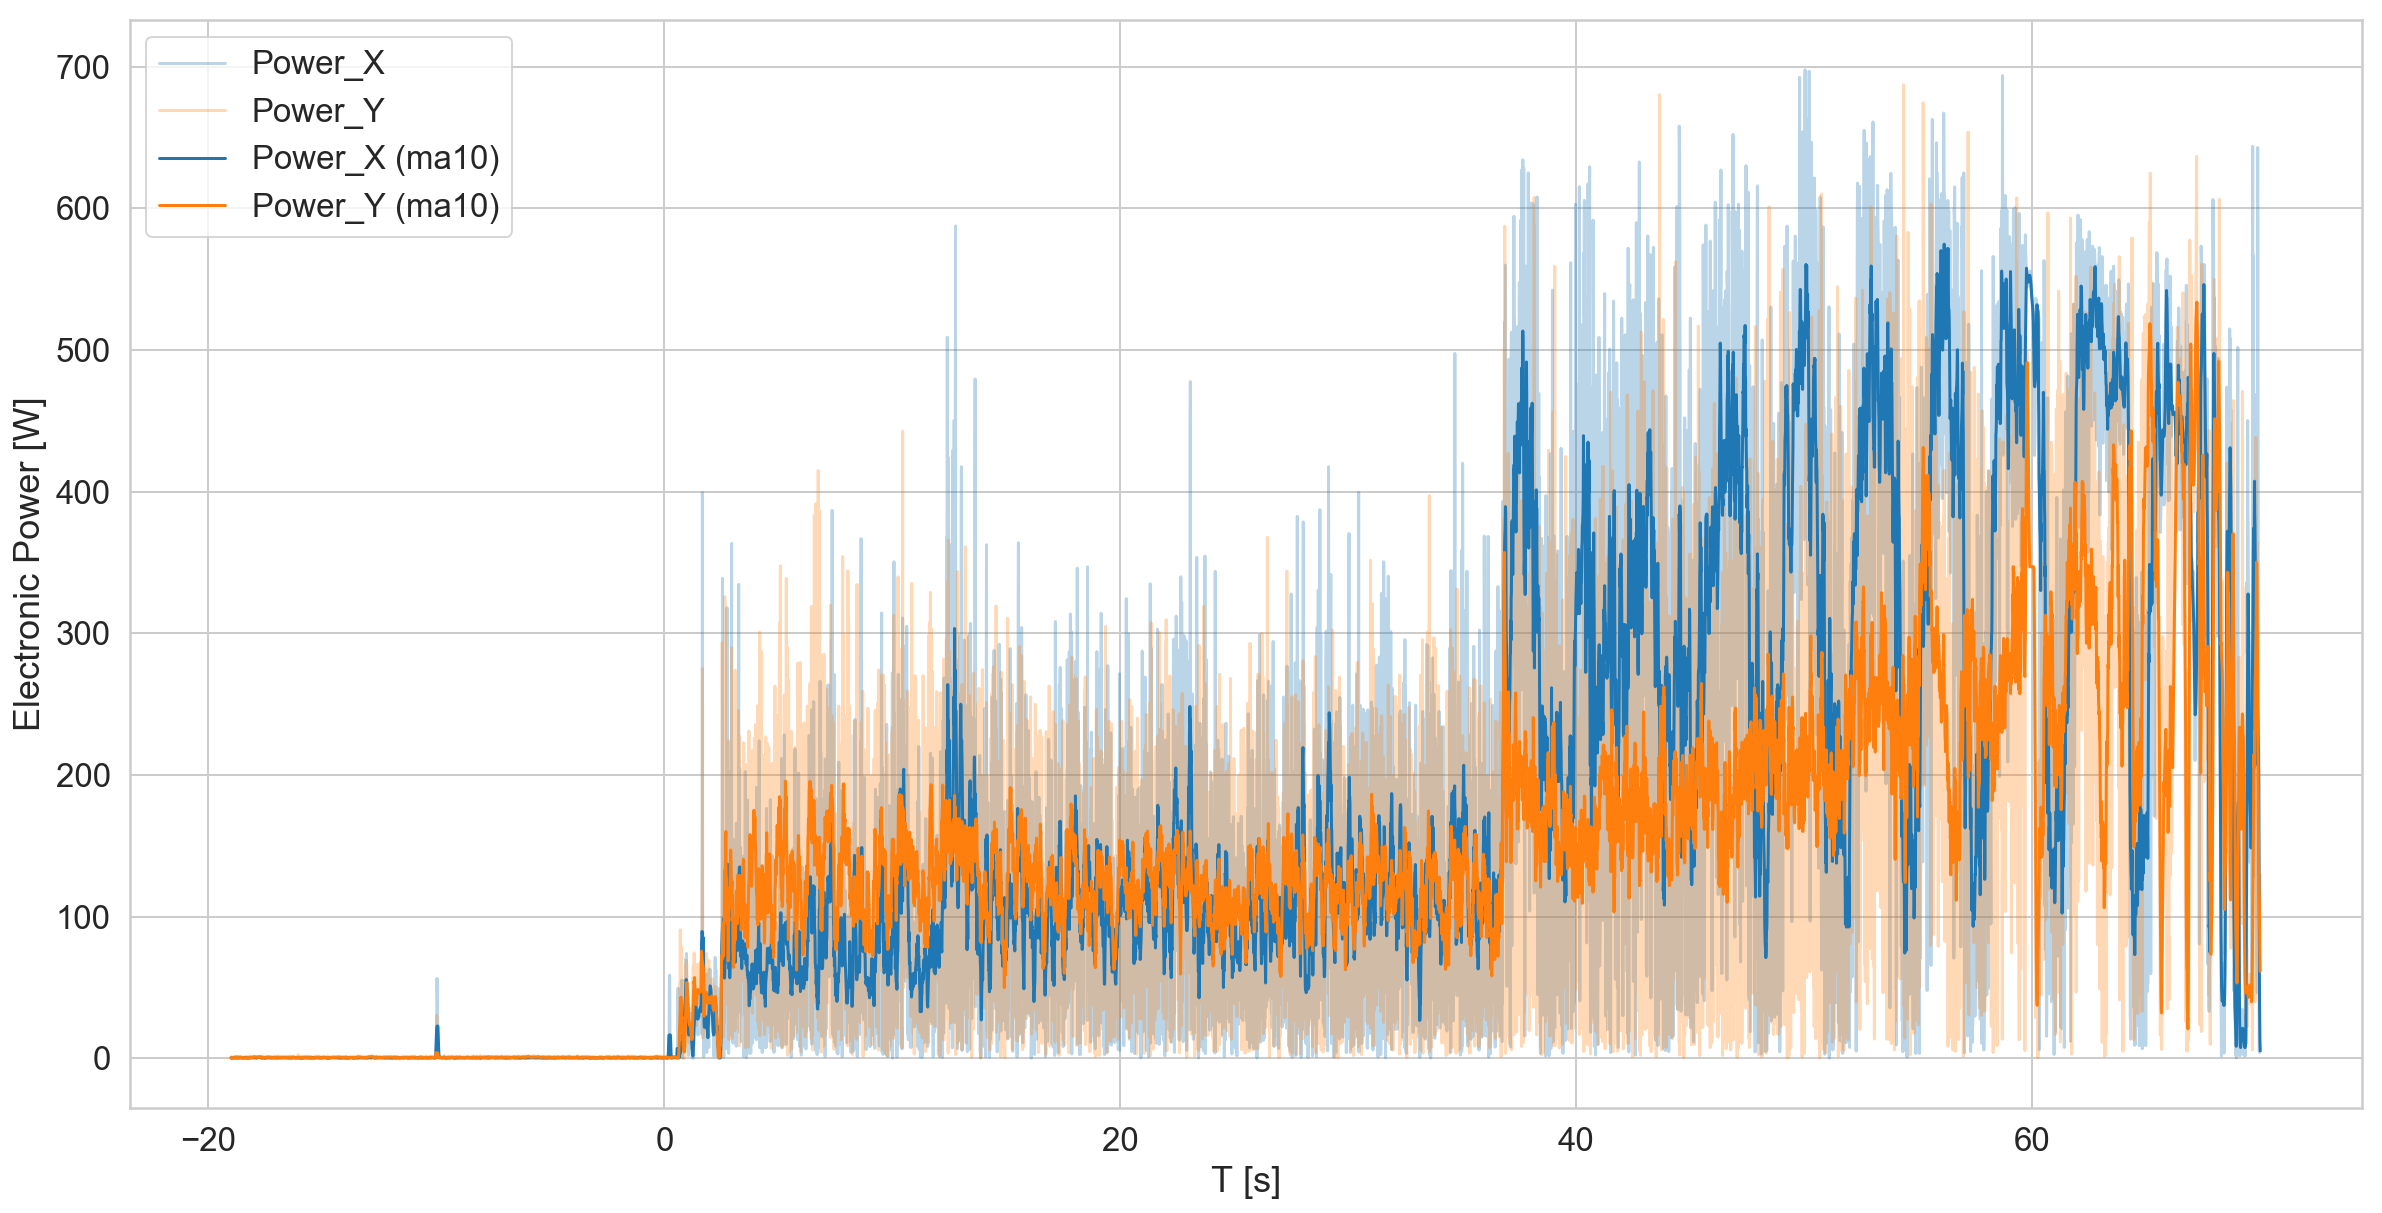

In [20]:
# モータ入力電力(入力電圧*モータ供給電流)

power_a = np.multiply(gimbal_a_voltage, np.abs(gimbal_a_current))
power_b = np.multiply(gimbal_b_voltage, np.abs(gimbal_b_current))

window = 10
c_window = np.ones(window)/window
power_a_ma = np.convolve(power_a, c_window, mode='same')
power_b_ma = np.convolve(power_b, c_window, mode='same')

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(t_gimbal, power_a, label='Power_X', alpha=0.3)
plt.plot(t_gimbal, power_b, label='Power_Y', alpha=0.3)
plt.plot(t_gimbal, power_a_ma, label='Power_X (ma10)', color=color_cycle[0])
plt.plot(t_gimbal, power_b_ma, label='Power_Y (ma10)', color=color_cycle[1])

plt.legend()

plt.ylabel('Electronic Power [W]')
plt.xlabel('T [s]')

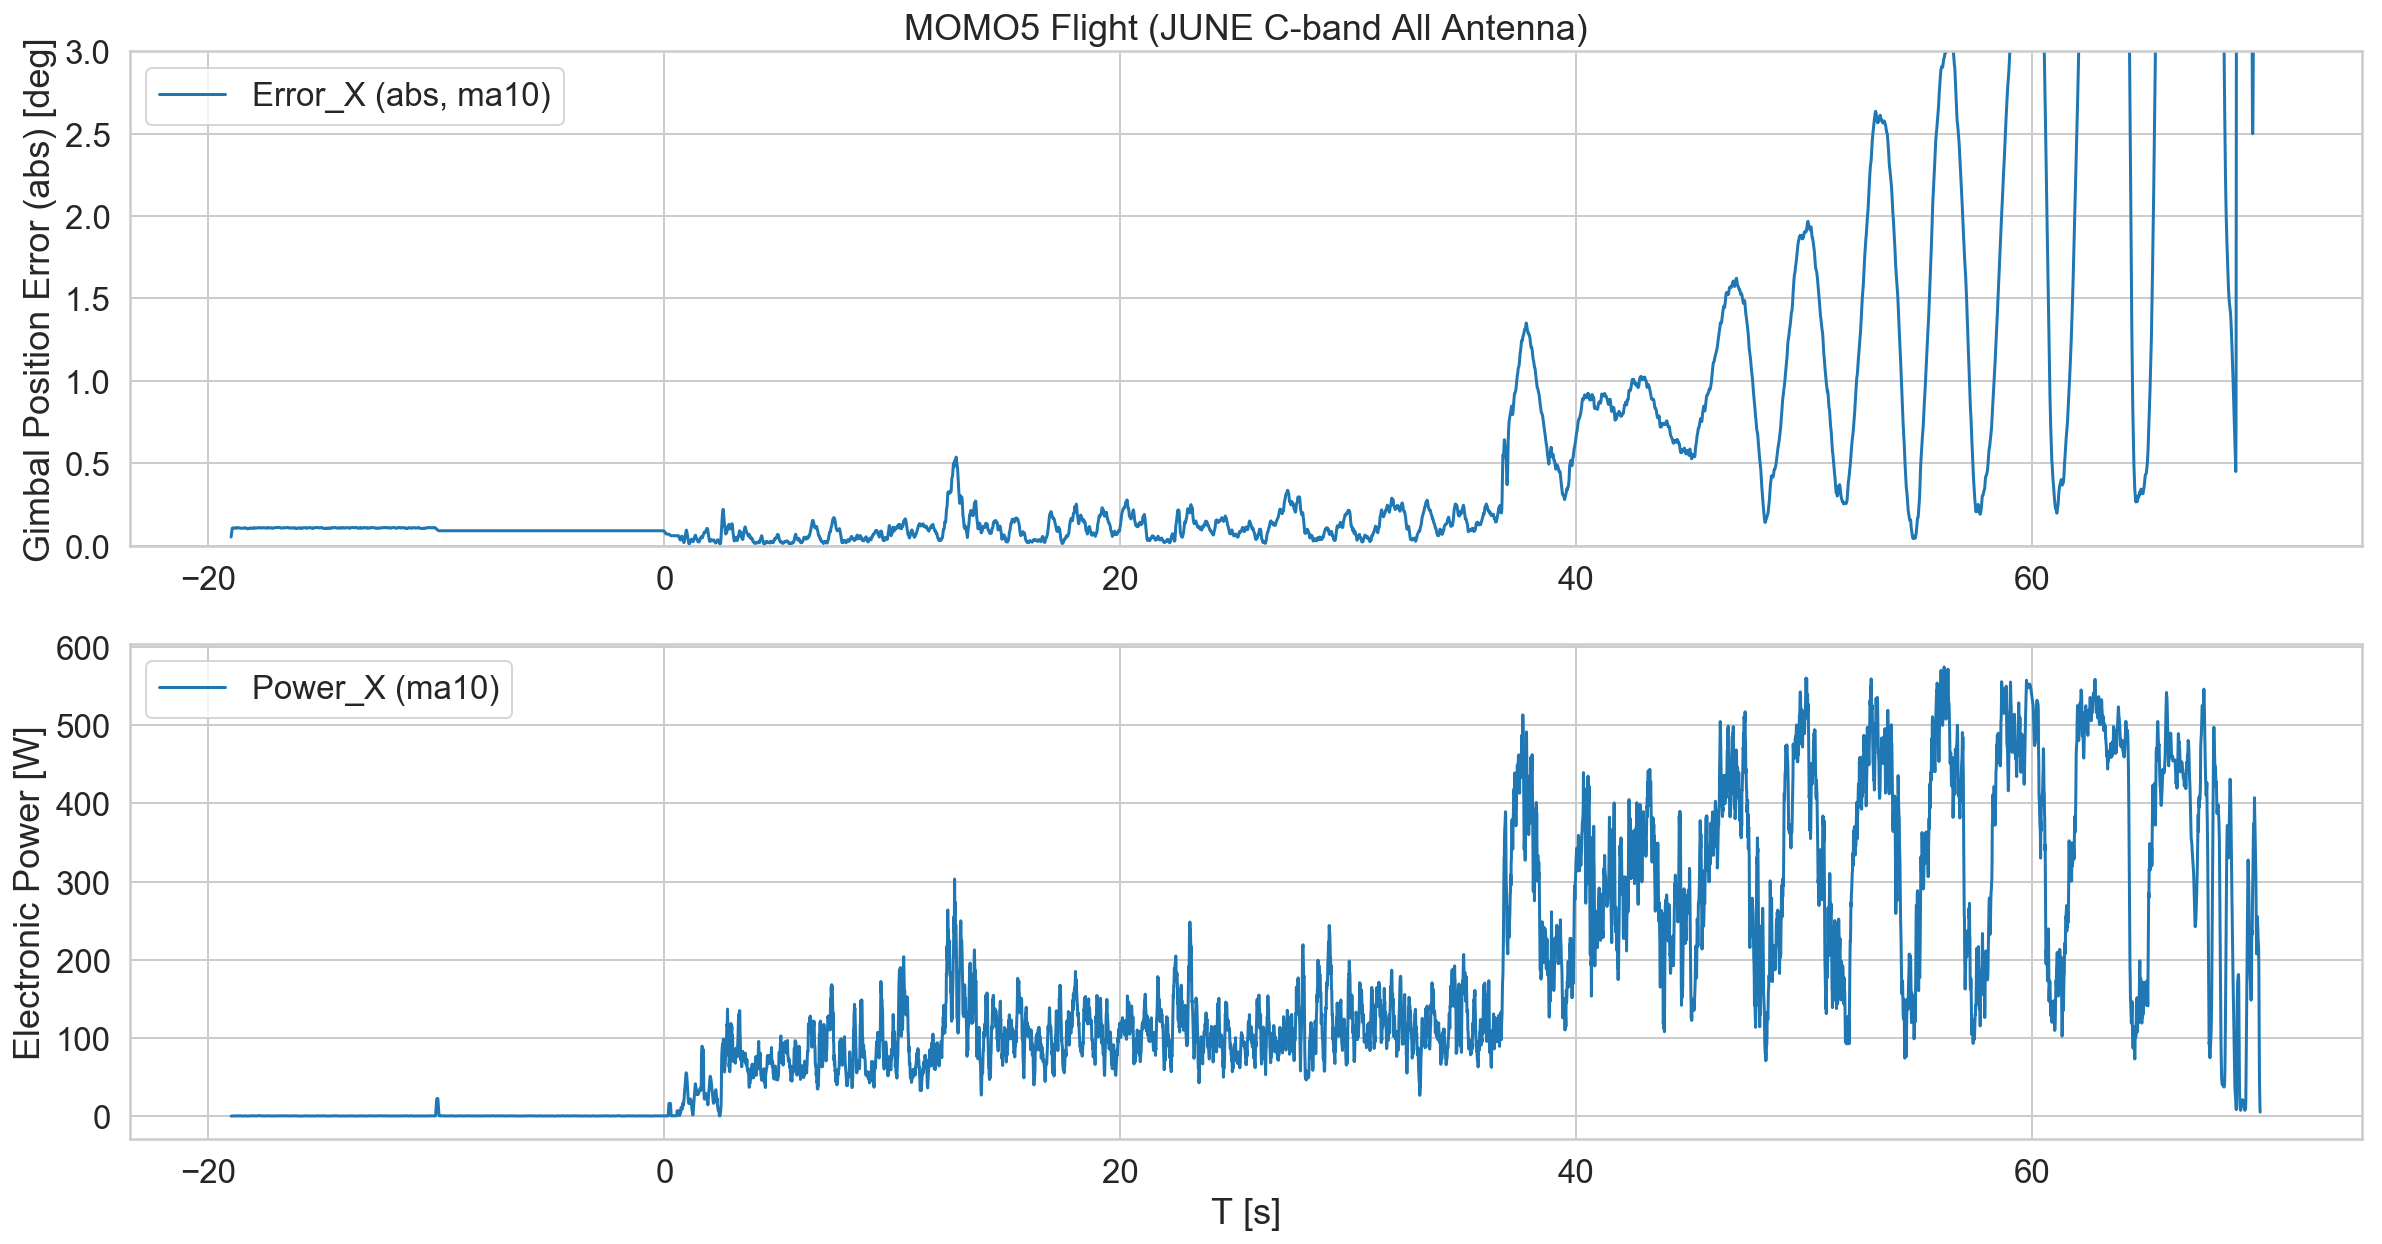

In [21]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
#fig, ax1 = plt.subplots()
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(t_gimbal, position_error_a_ma, label='Error_X (abs, ma10)')
ax1.set_ylim(0,3)
ax1.set_ylabel('Gimbal Position Error (abs) [deg]')
ax1.legend()
ax2.plot(t_gimbal, power_a_ma, label='Power_X (ma10)')
ax2.set_ylabel('Electronic Power [W]')
ax2.legend()
plt.xlabel('T [s]')
ax1.set_title(title)
plt.savefig(title + '_gimbal_pos_error_vs_epower_x.png', dpi=300)

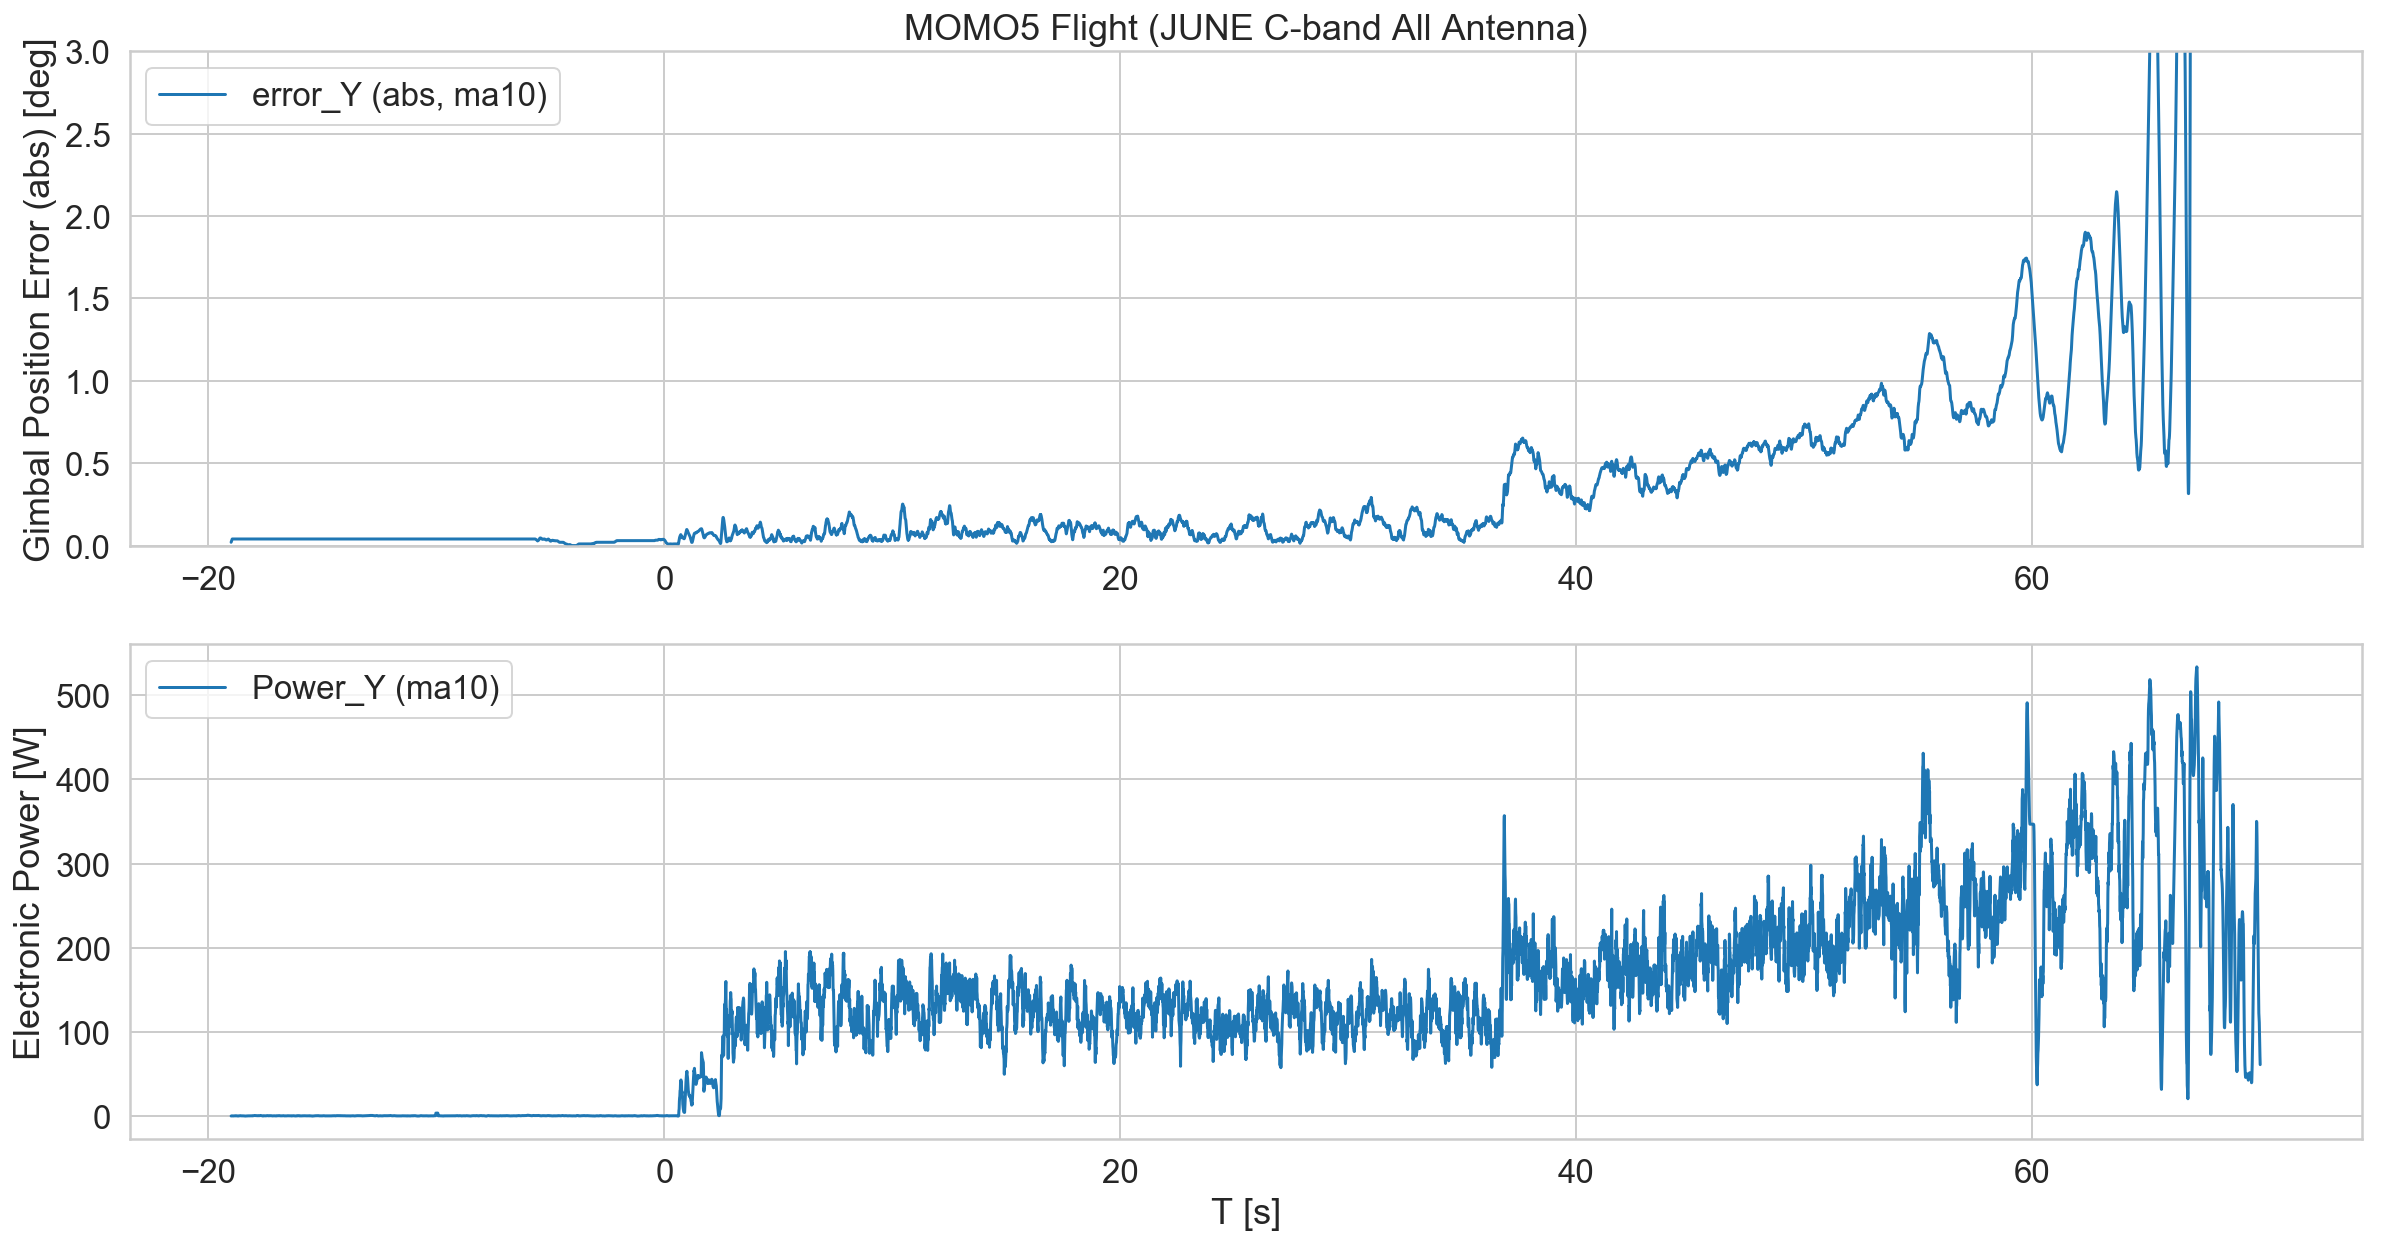

In [22]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
#fig, ax1 = plt.subplots()
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(t_gimbal, position_error_b_ma, label='error_Y (abs, ma10)')
ax1.set_ylim(0,3)
ax1.set_ylabel('Gimbal Position Error (abs) [deg]')
ax1.legend()
ax2.plot(t_gimbal, power_b_ma, label='Power_Y (ma10)')
ax2.set_ylabel('Electronic Power [W]')
ax2.legend()
plt.xlabel('T [s]')
ax1.set_title(title)
plt.savefig(title + '_gimbal_pos_error_vs_epower_y.png', dpi=300)